In [1]:
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


%matplotlib inline

In [2]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

# Ca2+ as a predictor of stimulus presence
### All dendrites

In [3]:
filename =filelist[0]
f = h5py.File(filename+".hdf5", "r")
amp = 3

stims = np.unique(h5py.File(filename+".hdf5", "r")['meta'][:,1])[1:]        #exclude zero

assert(amp in list(stims)), "this stimAmp was not used in chosen experiment. Cose one from {}.".format(stims)

test_size = 0.33
svm_kernel = 'linear'
baseav = False

n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

clf = svm.SVC(kernel=svm_kernel)

means = []
stds = []
for site in range(n_dendrites):

    data = f['data']
    meta = f['meta']

    baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)
    if baseav == True:
        baseline = np.mean(baseline, axis=0)

    mn_dnd_chng = np.mean(data[:,:,58:116]-baseline, axis=2)

    present_mask = meta[:,1]==amp
    absent_mask = meta[:,1]==0

    trials_mask = np.logical_or(present_mask, absent_mask)

    y_score = mn_dnd_chng[trials_mask, site]

    amp_mask = meta[:,1][trials_mask]==amp
    y_true = (amp_mask-0.5)*2
    X_train, X_test, y_train, y_test = train_test_split(y_score, y_true, test_size=test_size)
    
    #clf.fit(X_train.reshape(X_train.shape[0], 1), y_train.reshape(y_train.shape[0], 1))
    scores = cross_val_score(clf, y_score.reshape(y_score.shape[0], 1), y_true.reshape(y_true.shape[0]), cv=5)
    mean = scores.mean()
    stdv = scores.std()
    means.append(mean)
    stds.append(stdv)
                             
    print("For recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(site, mean, stdv*2))

For recording site 0: accuracy:  0.85 (+/-  0.14)
For recording site 1: accuracy:  0.80 (+/-  0.14)
For recording site 2: accuracy:  0.42 (+/-  0.10)
For recording site 3: accuracy:  0.60 (+/-  0.24)
For recording site 4: accuracy:  0.52 (+/-  0.10)
For recording site 5: accuracy:  0.45 (+/-  0.11)
For recording site 6: accuracy:  0.55 (+/-  0.14)
For recording site 7: accuracy:  0.52 (+/-  0.05)
For recording site 8: accuracy:  0.71 (+/-  0.16)
For recording site 9: accuracy:  0.48 (+/-  0.05)
For recording site 10: accuracy:  0.59 (+/-  0.12)
For recording site 11: accuracy:  0.54 (+/-  0.16)
For recording site 12: accuracy:  0.47 (+/-  0.05)
For recording site 13: accuracy:  0.56 (+/-  0.04)
For recording site 14: accuracy:  0.54 (+/-  0.12)
For recording site 15: accuracy:  0.53 (+/-  0.14)
For recording site 16: accuracy:  0.53 (+/-  0.10)
For recording site 17: accuracy:  0.62 (+/-  0.19)
For recording site 18: accuracy:  0.58 (+/-  0.14)
For recording site 19: accuracy:  0.51 (+

In [4]:
n_out = 6
inds = np.argsort(means)[::-1]

print("{} recordings sites best for classification:".format(n_out))
for i in range(n_out):
    print("At recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(inds[i], means[inds[i]], stds[inds[i]]*2))

6 recordings sites best for classification:
At recording site 109: accuracy:  0.90 (+/-  0.21)
At recording site 0: accuracy:  0.85 (+/-  0.14)
At recording site 66: accuracy:  0.83 (+/-  0.15)
At recording site 111: accuracy:  0.83 (+/-  0.19)
At recording site 114: accuracy:  0.82 (+/-  0.14)
At recording site 97: accuracy:  0.81 (+/-  0.12)


(0, 1)

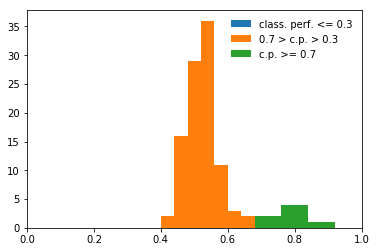

In [5]:
means = np.asarray(means)

lo_mask = means <= 0.3
mid_mask = np.logical_and(means >0.3, means < 0.7)
hi_mask = means >= 0.7

plt.hist(means[lo_mask], bins=50, range=(-1,1), label='class. perf. <= 0.3')
plt.hist(means[mid_mask], bins=50, range=(-1,1), label='0.7 > c.p. > 0.3')
plt.hist(means[hi_mask], bins=50, range=(-1,1), label='c.p. >= 0.7')
plt.legend(frameon=False)
plt.xlim(0,1)

# Ca2+ as a predictor for hit/miss
### all dendrites

In [89]:
amp = 1

test_size = 0.33
svm_kernel = 'linear'
baseav = False

n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

clf = svm.SVC(kernel=svm_kernel, class_weight='balanced')

means = []
stds = []
bals = []
ns = []
for site in range(n_dendrites):

    data = f['data']
    meta = f['meta']

    baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)
    if baseav == True:
        baseline = np.mean(baseline, axis=0)

    mn_dnd_chng = np.mean(data[:,:,58:116]-baseline, axis=2)

    present_mask = meta[:,1]==amp
    #absent_mask = meta[:,1]==0

    #trials_mask = np.logical_or(present_mask, absent_mask)
    trials_mask = present_mask

    y_score = mn_dnd_chng[trials_mask, site]

    hit_mask = meta[:, 2]==1
    
    #print(data[trials_mask])
    
    end_mask = hit_mask[trials_mask]
    y_true = (end_mask-0.5)*2
    
    balance = np.sum(end_mask)/end_mask.shape[0]
    n_y = end_mask.shape[0]
    
    bals.append(balance)
    ns.append(n_y)
    
    X_train, X_test, y_train, y_test = train_test_split(y_score, y_true, test_size=test_size)
    
    #clf.fit(X_train.reshape(X_train.shape[0], 1), y_train.reshape(y_train.shape[0], 1))
    scores = cross_val_score(clf, y_score.reshape(y_score.shape[0], 1), y_true.reshape(y_true.shape[0]), cv=5)
    mean = scores.mean()
    stdv = scores.std()
    means.append(mean)
    stds.append(stdv)
                             
    print("For recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(site, mean, stdv*2))

For recording site 0: accuracy:  0.89 (+/-  0.29)
For recording site 1: accuracy:  0.95 (+/-  0.15)
For recording site 2: accuracy:  0.45 (+/-  0.15)
For recording site 3: accuracy:  0.60 (+/-  0.09)
For recording site 4: accuracy:  0.70 (+/-  0.10)
For recording site 5: accuracy:  0.44 (+/-  0.16)
For recording site 6: accuracy:  0.38 (+/-  0.12)
For recording site 7: accuracy:  0.48 (+/-  0.27)
For recording site 8: accuracy:  0.56 (+/-  0.04)
For recording site 9: accuracy:  0.54 (+/-  0.10)
For recording site 10: accuracy:  0.46 (+/-  0.04)
For recording site 11: accuracy:  0.58 (+/-  0.18)
For recording site 12: accuracy:  0.52 (+/-  0.19)
For recording site 13: accuracy:  0.61 (+/-  0.29)
For recording site 14: accuracy:  0.52 (+/-  0.16)
For recording site 15: accuracy:  0.51 (+/-  0.30)
For recording site 16: accuracy:  0.53 (+/-  0.31)
For recording site 17: accuracy:  0.62 (+/-  0.08)
For recording site 18: accuracy:  0.48 (+/-  0.28)
For recording site 19: accuracy:  0.44 (+

In [90]:
n_out = 6
inds = np.argsort(means)[::-1]

print("{} recordings sites best for classification:".format(n_out))
for i in range(n_out):
    print("At recording site {0}: accuracy: {1: .2f} (+/- {2: .2f}) with a positive label fraction of {3: .2f} out of {4}".format(inds[i], means[inds[i]], stds[inds[i]]*2, bals[inds[i]], ns[inds[i]]))

6 recordings sites best for classification:
At recording site 1: accuracy:  0.95 (+/-  0.15) with a positive label fraction of  0.44 out of 50
At recording site 0: accuracy:  0.89 (+/-  0.29) with a positive label fraction of  0.44 out of 50
At recording site 114: accuracy:  0.86 (+/-  0.09) with a positive label fraction of  0.44 out of 50
At recording site 98: accuracy:  0.79 (+/-  0.19) with a positive label fraction of  0.44 out of 50
At recording site 91: accuracy:  0.71 (+/-  0.23) with a positive label fraction of  0.44 out of 50
At recording site 50: accuracy:  0.70 (+/-  0.38) with a positive label fraction of  0.44 out of 50


# Ca2+ as a predictor for stimulus presence
### combination of all dendrites

In [ ]:
filename = filelist[0]

f = h5py.File(filename+".hdf5", "r")
stims = np.unique(f['meta'][:,1])[1:]        #exclude zero
test_size = 0.33
svm_kernel = 'linear'
baseav = False

sc = []
for amp in stims:
    #average delta F
    #1s = 58 frames
    data = f['data']
    meta = f['meta']

    baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)
    if baseav == True:
        baseline = np.mean(baseline, axis=0)

    mn_dnd_chng = np.mean(data[:,:,58:116]-baseline, axis=2)

    present_mask = meta[:,1]==amp
    absent_mask = meta[:,1]==0

    trials_mask = np.logical_or(present_mask, absent_mask)

    y_score = mn_dnd_chng[trials_mask, :]

    amp_mask = meta[:,1][trials_mask]==amp
    y_true = (amp_mask-0.5)*2

    n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

    clf = svm.SVC(kernel=svm_kernel)
    scores = cross_val_score(clf, y_score, y_true.reshape(y_true.shape[0]), cv=10)
    sc.append(scores)

In [9]:
for k, scores in enumerate(sc):
    print("For stimApm {0: .2f}: accuracy: {1: .2f} (+/- {2: .2f})".format(stims[k], np.mean(scores), 2*np.std(scores)))

For stimApm  0.50: accuracy:  0.46 (+/-  0.13)
For stimApm  1.00: accuracy:  0.66 (+/-  0.24)
For stimApm  1.50: accuracy:  0.68 (+/-  0.15)
For stimApm  2.00: accuracy:  0.79 (+/-  0.30)
For stimApm  2.50: accuracy:  0.83 (+/-  0.28)
For stimApm  3.00: accuracy:  0.95 (+/-  0.16)


<Container object of 3 artists>

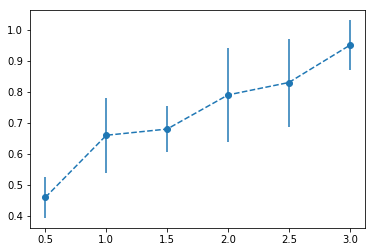

In [10]:
sc = np.array(sc)
means = np.mean(sc, axis=1)
std = np.std(sc, axis=1)

plt.errorbar(stims, means, yerr=std, fmt='--o')

# Ca2+ as a predictor for hit/miss
### combination of all dendrites

In [67]:
filename = filelist[0]

f = h5py.File(filename+".hdf5", "r")
stims = np.unique(f['meta'][:,1])[1:]        #exclude zero
test_size = 0.33
svm_kernel = 'linear'
baseav = False

sc = []
bals = []
ns = []
for amp in stims:
    #average delta F
    #1s = 58 frames
    data = f['data']
    meta = f['meta']

    baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)
    if baseav == True:
        baseline = np.mean(baseline, axis=0)

    mn_dnd_chng = np.mean(data[:,:,58:116]-baseline, axis=2)

    present_mask = meta[:,1]==amp
    #absent_mask = meta[:,1]==0

    #trials_mask = np.logical_or(present_mask, absent_mask)
    trials_mask = present_mask
    
    y_score = mn_dnd_chng[trials_mask, :]

    hit_mask = meta[:, 2]==1
    
    #print(data[trials_mask])
    
    end_mask = hit_mask[trials_mask]
    y_true = (end_mask-0.5)*2
    
    balance = np.sum(end_mask)/end_mask.shape[0]
    n_y = end_mask.shape[0]
    
    bals.append(balance)
    ns.append(n_y)

    n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

    clf = svm.SVC(kernel=svm_kernel, class_weight='balanced')
    scores = cross_val_score(clf, y_score, y_true.reshape(y_true.shape[0]), cv=4)
    sc.append(scores)

In [68]:
for k, scores in enumerate(sc):
    print("For stimApm {0: .2f}: accuracy: {1: .2f} (+/- {2: .2f})".format(stims[k], np.mean(scores), 2*np.std(scores)))

For stimApm  0.50: accuracy:  0.88 (+/-  0.07)
For stimApm  1.00: accuracy:  0.84 (+/-  0.12)
For stimApm  1.50: accuracy:  0.76 (+/-  0.19)
For stimApm  2.00: accuracy:  0.84 (+/-  0.18)
For stimApm  2.50: accuracy:  0.76 (+/-  0.22)
For stimApm  3.00: accuracy:  0.76 (+/-  0.11)


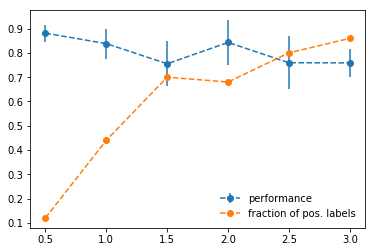

In [69]:
sc = np.array(sc)
means = np.mean(sc, axis=1)
std = np.std(sc, axis=1)

plt.errorbar(stims, means, yerr=std, fmt='--o', label='performance')
plt.errorbar(stims, bals, fmt='--o', label='fraction of pos. labels')
plt.legend(frameon=False)

# Comparison of averaging windows, hit/miss

In [92]:
#most informative time
filename = filelist[0]

f = h5py.File(filename+".hdf5", "r")
stims = np.unique(f['meta'][:,1])[1:]        #exclude zero
test_size = 0.33
svm_kernel = 'linear'
baseav = False

bals = []
ns = []

n_shift = 2
av_time = 58
n_times = f['data'].shape[2]
start_inds = np.arange(0,n_times-av_time, 2)
bl_time = 58

scs = []
for start in start_inds:
    sc = []
    for amp in stims:
        #average delta F
        #1s = 58 frames
        data = f['data']
        meta = f['meta']

        baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)
        if baseav == True:
            baseline = np.mean(baseline, axis=0)
        
        #if the averaging window is before the stimulus, do not subtract baseline
        #if start < bl_time:
        #    baseline = np.zeros((baseline.shape[0], baseline.shape[1], baseline.shape[2]))
        
        baseline = baseline*1/bl_time*start

        mn_dnd_chng = np.mean(data[:,:,start:start+av_time]-baseline, axis=2)

        present_mask = meta[:,1]==amp
        #absent_mask = meta[:,1]==0

        #trials_mask = np.logical_or(present_mask, absent_mask)
        trials_mask = present_mask

        y_score = mn_dnd_chng[trials_mask, :]

        hit_mask = meta[:, 2]==1

        #print(data[trials_mask])

        end_mask = hit_mask[trials_mask]
        y_true = (end_mask-0.5)*2

        balance = np.sum(end_mask)/end_mask.shape[0]
        n_y = end_mask.shape[0]

        bals.append(balance)
        ns.append(n_y)

        n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

        clf = svm.SVC(kernel=svm_kernel, class_weight='balanced')
        scores = cross_val_score(clf, y_score, y_true.reshape(y_true.shape[0]), cv=5)
        sc.append(scores)
    scs.append(sc)

Best time window on average: 50:108
Best time window on max. stim: 112:170
Best time window on min. stim: 60:118


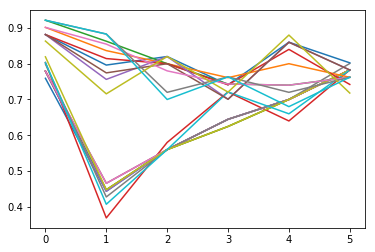

In [93]:
scs = np.array(scs)
m_scs = np.mean(scs, axis=2)
m_vals = np.mean(m_scs, axis=1)
inds = np.argsort(m_vals)

#max_vals = np.mean(m_scs[:,5])
#min_vals = np.mean(m_scs[:,0])
max_inds = np.argsort(m_scs[:,5])
min_inds = np.argsort(m_scs[:,0])

for i in inds[:10]:
    plt.plot(m_scs[i])
    
for i in inds[::-1][:10]:
    plt.plot(m_scs[i])
    
print('Best time window on average: {}:{}'.format((inds[::-1][0])*2, (inds[::-1][0])*2+av_time))
print('Best time window on max. stim: {}:{}'.format((max_inds[::-1][0])*2, (max_inds[::-1][0])*2+av_time))
print('Best time window on min. stim: {}:{}'.format((min_inds[::-1][0])*2, (min_inds[::-1][0])*2+av_time))

# Comparisom of averaging windows, stimulus presence
### how to go about baseline?

In [3]:
filename = filelist[0]

f = h5py.File(filename+".hdf5", "r")
stims = np.unique(f['meta'][:,1])[1:]        #exclude zero
test_size = 0.33
svm_kernel = 'linear'
baseav = False

n_shift = 2
av_time = 58
n_times = f['data'].shape[2]
start_inds = np.arange(0,n_times-av_time, 2)
bl_time = 58

scs = []
for start in start_inds:
    sc = []
    for amp in stims:
        #average delta F
        #1s = 58 frames
        data = f['data']
        meta = f['meta']

        baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)
        if baseav == True:
            baseline = np.mean(baseline, axis=0)
            
        baseline = baseline*1/bl_time*start
            
        #if start < bl_time:
        #    baseline = np.zeros((baseline.shape[0], baseline.shape[1], baseline.shape[2]))

        mn_dnd_chng = np.mean(data[:,:,start:start+av_time]-baseline, axis=2)

        present_mask = meta[:,1]==amp
        absent_mask = meta[:,1]==0

        trials_mask = np.logical_or(present_mask, absent_mask)

        y_score = mn_dnd_chng[trials_mask, :]

        amp_mask = meta[:,1][trials_mask]==amp
        y_true = (amp_mask-0.5)*2

        n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

        clf = svm.SVC(kernel=svm_kernel)
        scores = cross_val_score(clf, y_score, y_true.reshape(y_true.shape[0]), cv=10)
        sc.append(scores)
    scs.append(sc)

Best time window on average: 64:122 with av. accuracy 0.6368306010928962
Best time window on max. stim: 58:116
Second best time window on max. stim: 60:118
Third best time window on max. stim: 54:112
Best time window on min. stim: 46:104
Second best time window on min. stim: 44:102
Second best time window on min. stim: 38:96


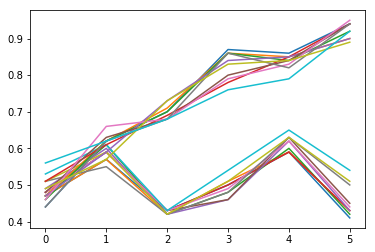

In [4]:
scs = np.array(scs)
m_scs = np.mean(scs, axis=2)
m_vals = np.mean(m_scs, axis=1)
inds = np.argsort(m_vals)

#max_vals = np.mean(m_scs[:,5])
#min_vals = np.mean(m_scs[:,0])
max_inds = np.argsort(m_scs[:,5])
min_inds = np.argsort(m_scs[:,0])

for i in inds[:10]:
    plt.plot(m_scs[i])
    
for i in inds[::-1][:10]:
    plt.plot(m_scs[i])
    
print('Best time window on average: {}:{}'.format((inds[::-1][0])*2, (inds[::-1][0])*2+av_time))

print('Best time window on max. stim: {}:{}'.format((max_inds[::-1][0])*2, (max_inds[::-1][0])*2+av_time))
print('Second best time window on max. stim: {}:{}'.format((max_inds[::-1][1])*2, (max_inds[::-1][1])*2+av_time))
print('Third best time window on max. stim: {}:{}'.format((max_inds[::-1][2])*2, (max_inds[::-1][2])*2+av_time))

print('Best time window on min. stim: {}:{}'.format((min_inds[::-1][0])*2, (min_inds[::-1][0])*2+av_time))
print('Second best time window on min. stim: {}:{}'.format((min_inds[::-1][1])*2, (min_inds[::-1][1])*2+av_time))
print('Second best time window on min. stim: {}:{}'.format((min_inds[::-1][2])*2, (min_inds[::-1][2])*2+av_time))

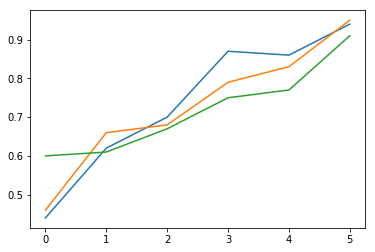

In [24]:
plt.plot(m_scs[inds[::-1][0]])
plt.plot(m_scs[max_inds[::-1][0]])
plt.plot(m_scs[min_inds[::-1][0]])

In [13]:
#most informative time
filename = filelist[0]

f = h5py.File(filename+".hdf5", "r")
stims = np.unique(f['meta'][:,1])        #exclude zero
test_size = 0.33
svm_kernel = 'linear'
baseav = False

bals = []
ns = []

n_shift = 2
#av_time = 58
n_times = f['data'].shape[2]
start_inds = np.arange(0,n_times-1, 2)
bl_time = 58

s_nr = 7
cv = 4
size_min = 2
size_max = 120
size_step = 2

av_times = np.arange(size_min, size_max, size_step)

scs = np.zeros((start_inds.shape[0], av_times.shape[0], s_nr, cv))

data = f['data']
meta = f['meta']

for i, start in enumerate(start_inds):
    for j, av_time in enumerate(av_times):
        for k, amp in enumerate(stims[:s_nr]):
            #average delta F
            #1s = 58 frames

            baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)
            if baseav == True:
                baseline = np.mean(baseline, axis=0)

            #if the averaging window is before the stimulus, do not subtract baseline
            if start+av_time < bl_time:
                baseline = np.zeros((baseline.shape[0], baseline.shape[1], baseline.shape[2]))

            #baseline = baseline*1/bl_time*start

            end = start+av_time
            if  end > data.shape[2]:
                end = data.shape[2]
                
            mn_dnd_chng = np.mean(data[:,:,start:end]-baseline, axis=2)

            present_mask = meta[:,1]==amp
            #absent_mask = meta[:,1]==0

            #trials_mask = np.logical_or(present_mask, absent_mask)
            trials_mask = present_mask

            y_score = mn_dnd_chng[trials_mask, :]

            hit_mask = meta[:, 2]==1

            #print(data[trials_mask])

            end_mask = hit_mask[trials_mask]
            y_true = (end_mask-0.5)*2

            balance = np.sum(end_mask)/end_mask.shape[0]
            n_y = end_mask.shape[0]

            bals.append(balance)
            ns.append(n_y)

            n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

            clf = svm.SVC(kernel=svm_kernel, class_weight='balanced')
            scores = cross_val_score(clf, y_score, y_true.reshape(y_true.shape[0]), cv=cv)
            
            scs[i, j, k, :] = scores
    print('{}st iteration out of {}'.format(i+1, start_inds.shape[0]))
            #print('window: {0}:{1}, stimAmp: {2: .2f}, score: {3: .2f}'.format(start, start+av_time, amp, np.mean(scores)))

1st iteration out of 90
2st iteration out of 90
3st iteration out of 90
4st iteration out of 90
5st iteration out of 90
6st iteration out of 90
7st iteration out of 90
8st iteration out of 90
9st iteration out of 90
10st iteration out of 90
11st iteration out of 90
12st iteration out of 90
13st iteration out of 90
14st iteration out of 90
15st iteration out of 90
16st iteration out of 90
17st iteration out of 90
18st iteration out of 90
19st iteration out of 90
20st iteration out of 90
21st iteration out of 90
22st iteration out of 90
23st iteration out of 90
24st iteration out of 90
25st iteration out of 90
26st iteration out of 90
27st iteration out of 90
28st iteration out of 90
29st iteration out of 90
30st iteration out of 90
31st iteration out of 90
32st iteration out of 90
33st iteration out of 90
34st iteration out of 90
35st iteration out of 90
36st iteration out of 90
37st iteration out of 90
38st iteration out of 90
39st iteration out of 90
40st iteration out of 90
41st iter

In [14]:
m_scs = np.mean(scs, axis=3)
np.where(m_scs[:,:,0] == m_scs[:,:,0].max())
#np.argmax(m_scs[:, 0, 0])
#m_scs.shape

(array([ 0,  0,  0,  1,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  7,  7,
         8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11,
        11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14,
        14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18,
        18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 22, 22,
        23, 23, 24, 24, 25, 26, 27, 27, 28, 28, 28, 29, 29, 29, 30, 31, 31,
        32, 32, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37,
        37, 37, 37, 38, 41, 42, 63, 63]),
 array([30, 32, 47, 45, 43, 41, 42, 40, 41, 38, 39, 37, 38, 35, 36, 37, 38,
        33, 34, 35, 36, 37, 32, 33, 34, 35, 36, 32, 33, 34, 35, 36, 31, 32,
        33, 34, 35, 30, 31, 32, 33, 34, 29, 30, 31, 32, 33, 28, 29, 30, 31,
        32, 28, 29, 30, 31, 27, 28, 29, 30, 25, 26, 27, 28, 29, 24, 25, 26,
        27, 28, 23, 24, 25, 26, 27, 22, 23, 24, 25, 26, 23, 24, 25, 14, 23,
        11, 12, 10, 11,  9,  8,  5,  6,  4,  5

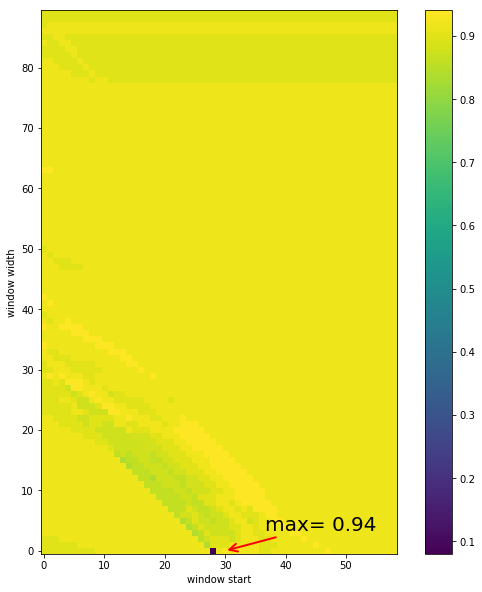

In [15]:
coords = np.where(m_scs[:,:,0] == m_scs[:,:,0].max())
plt.figure(figsize=(10,10))
plt.imshow(m_scs[:,:,0], origin='lower', interpolation='none')
plt.annotate('max={0: .2f}'.format(m_scs[:,:,0].max()), fontsize=20, xy=(coords[1][0], coords[0][0]),
            xycoords='data', xytext=(40, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.,
                            color = 'red'))
plt.xlabel('window start')
plt.ylabel('window width')
plt.colorbar()

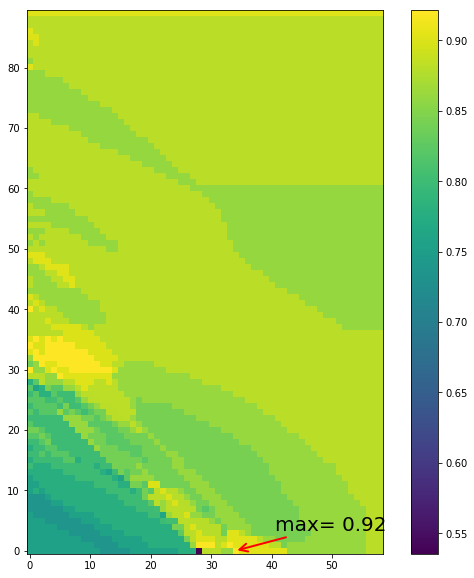

In [16]:
coords = np.where(m_scs[:,:,1] == m_scs[:,:,1].max())

plt.figure(figsize=(10,10))
plt.imshow(m_scs[:,:,1], origin='lower')
plt.annotate('max={0: .2f}'.format(m_scs[:,:,1].max()), fontsize=20, xy=(coords[1][0], coords[0][0]),
            xycoords='data', xytext=(40, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.,
                            color = 'red'))
plt.colorbar()

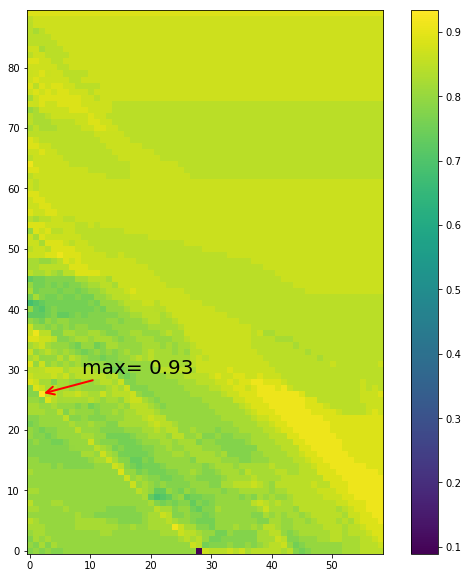

In [7]:
coords = np.where(m_scs[:,:,2] == m_scs[:,:,2].max())

plt.figure(figsize=(10,10))
plt.imshow(m_scs[:,:,2], origin='lower')
plt.annotate('max={0: .2f}'.format(m_scs[:,:,2].max()), fontsize=20, xy=(coords[1][0], coords[0][0]),
            xycoords='data', xytext=(40, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.,
                            color = 'red'))
plt.colorbar()

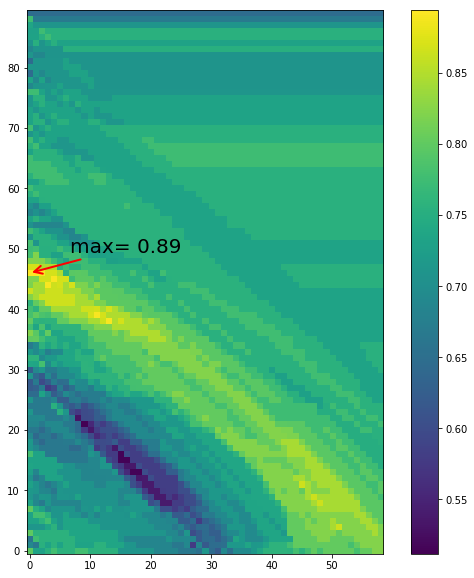

In [8]:
coords = np.where(m_scs[:,:,3] == m_scs[:,:,3].max())

plt.figure(figsize=(10,10))
plt.imshow(m_scs[:,:,3], origin='lower')
plt.annotate('max={0: .2f}'.format(m_scs[:,:,3].max()), fontsize=20, xy=(coords[1][0], coords[0][0]),
            xycoords='data', xytext=(40, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.,
                            color = 'red'))
plt.colorbar()

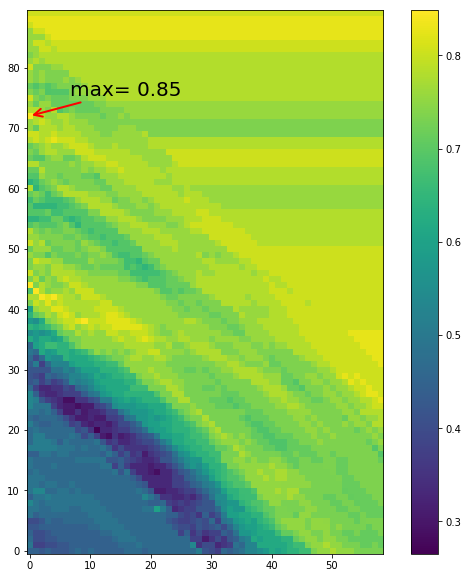

In [9]:
coords = np.where(m_scs[:,:,4] == m_scs[:,:,4].max())

plt.figure(figsize=(10,10))
plt.imshow(m_scs[:,:,4], origin='lower')
plt.annotate('max={0: .2f}'.format(m_scs[:,:,4].max()), fontsize=20, xy=(coords[1][0], coords[0][0]),
            xycoords='data', xytext=(40, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.,
                            color = 'red'))
plt.colorbar()

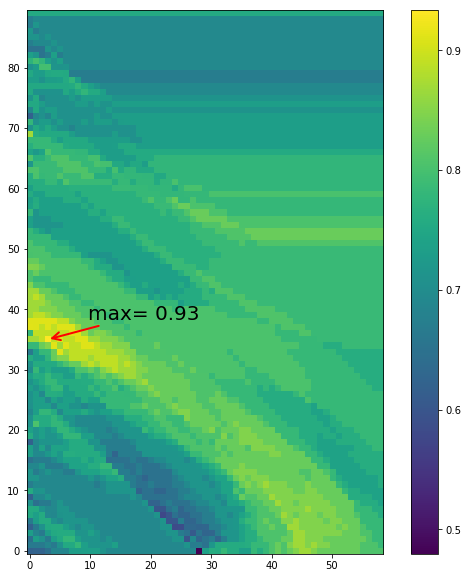

In [10]:
coords = np.where(m_scs[:,:,5] == m_scs[:,:,5].max())

plt.figure(figsize=(10,10))
plt.imshow(m_scs[:,:,5], origin='lower')
plt.annotate('max={0: .2f}'.format(m_scs[:,:,5].max()), fontsize=20, xy=(coords[1][0], coords[0][0]),
            xycoords='data', xytext=(40, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.,
                            color = 'red'))
plt.colorbar()

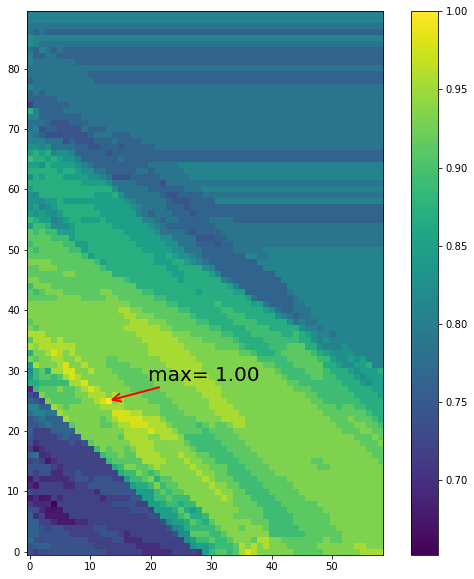

In [11]:
coords = np.where(m_scs[:,:,6] == m_scs[:,:,6].max())

plt.figure(figsize=(10,10))
plt.imshow(m_scs[:,:,6], origin='lower')
plt.annotate('max={0: .2f}'.format(m_scs[:,:,6].max()), fontsize=20, xy=(coords[1][0], coords[0][0]),
            xycoords='data', xytext=(40, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.,
                            color = 'red'))
plt.colorbar()

In [12]:
coords = np.where(m_scs[:,:,7] == m_scs[:,:,7].max())

plt.figure(figsize=(10,10))
plt.imshow(m_scs[:,:,7], origin='lower')
plt.annotate('max={0: .2f}'.format(m_scs[:,:,7].max()), fontsize=20, xy=(coords[1][0], coords[0][0]),
            xycoords='data', xytext=(40, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.,
                            color = 'red'))
plt.colorbar()

IndexError: index 7 is out of bounds for axis 2 with size 7

In [31]:
#most informative time
filename = filelist[0]

f = h5py.File(filename+".hdf5", "r")
stims = np.unique(f['meta'][:,1])        #exclude zero
test_size = 0.33
svm_kernel = 'linear'
baseav = False

bals = []
ns = []

n_shift = 2
#av_time = 58
n_times = f['data'].shape[2]
start_inds = np.arange(0,n_times-1, 2)
bl_time = 58

s_nr = 7
cv = 4
size_min = 2
size_max = 120
size_step = 2

av_times = np.arange(size_min, size_max, size_step)

scs = np.zeros((start_inds.shape[0], av_times.shape[0], s_nr, cv))

data = f['data']
meta = f['meta']

for i, start in enumerate(start_inds):
    for j, av_time in enumerate(av_times):
        for k, amp in enumerate(stims[1:]):

            baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)
            if baseav == True:
                baseline = np.mean(baseline, axis=0)

            if start+av_time < bl_time:
                baseline = np.zeros((baseline.shape[0], baseline.shape[1], baseline.shape[2]))

            #baseline = baseline*1/bl_time*start

            end = start+av_time
            if  end > data.shape[2]:
                end = data.shape[2]

            #if start < bl_time:
            #    baseline = np.zeros((baseline.shape[0], baseline.shape[1], baseline.shape[2]))

            mn_dnd_chng = np.mean(data[:,:,start:end]-baseline, axis=2)

            present_mask = meta[:,1]==amp
            absent_mask = meta[:,1]==0

            trials_mask = np.logical_or(present_mask, absent_mask)

            y_score = mn_dnd_chng[trials_mask, :]

            amp_mask = meta[:,1][trials_mask]==amp
            y_true = (amp_mask-0.5)*2

            n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

            clf = svm.SVC(kernel=svm_kernel)
            scores = cross_val_score(clf, y_score, y_true.reshape(y_true.shape[0]), cv=cv)
            scs[i,j,k,:] = scores

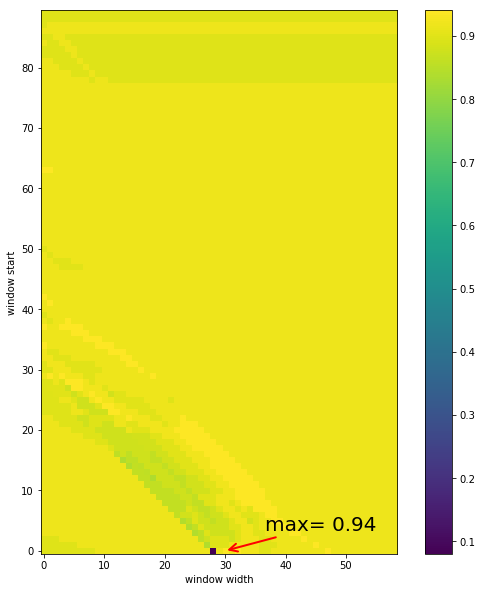

In [33]:
coords = np.where(m_scs[:,:,0] == m_scs[:,:,0].max())
plt.figure(figsize=(10,10))
plt.imshow(m_scs[:,:,0], origin='lower', interpolation='none')
plt.annotate('max={0: .2f}'.format(m_scs[:,:,0].max()), fontsize=20, xy=(coords[1][0], coords[0][0]),
            xycoords='data', xytext=(40, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.,
                            color = 'red'))
plt.xlabel('window width')
plt.ylabel('window start')
plt.colorbar()

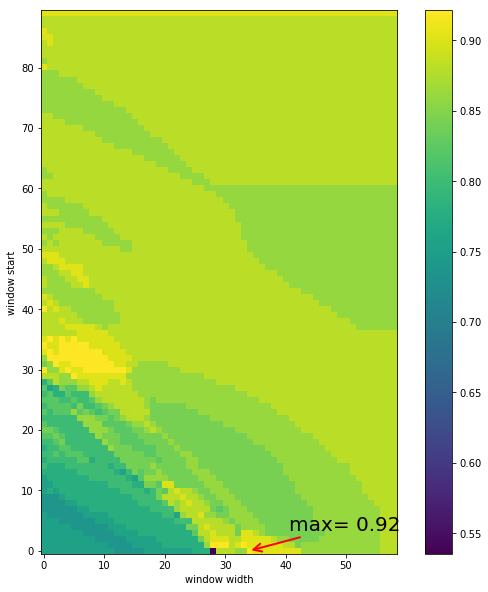

In [34]:
coords = np.where(m_scs[:,:,1] == m_scs[:,:,1].max())
plt.figure(figsize=(10,10))
plt.imshow(m_scs[:,:,1], origin='lower', interpolation='none')
plt.annotate('max={0: .2f}'.format(m_scs[:,:,1].max()), fontsize=20, xy=(coords[1][0], coords[0][0]),
            xycoords='data', xytext=(40, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.,
                            color = 'red'))
plt.xlabel('window width')
plt.ylabel('window start')
plt.colorbar()

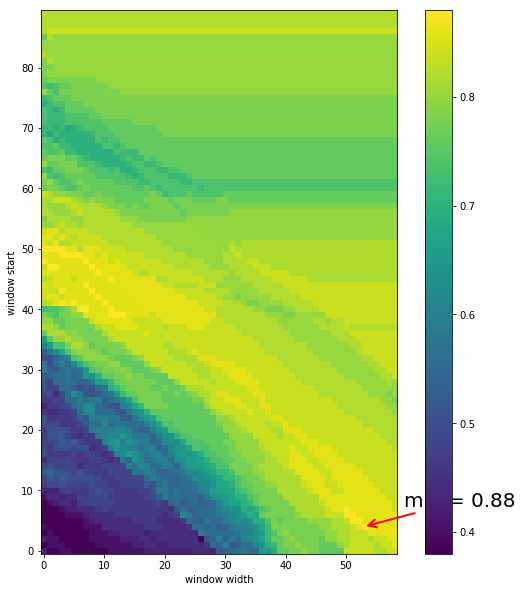

In [35]:
coords = np.where(m_scs[:,:,2] == m_scs[:,:,2].max())
plt.figure(figsize=(10,10))
plt.imshow(m_scs[:,:,2], origin='lower', interpolation='none')
plt.annotate('max={0: .2f}'.format(m_scs[:,:,2].max()), fontsize=20, xy=(coords[1][0], coords[0][0]),
            xycoords='data', xytext=(40, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.,
                            color = 'red'))
plt.xlabel('window width')
plt.ylabel('window start')
plt.colorbar()

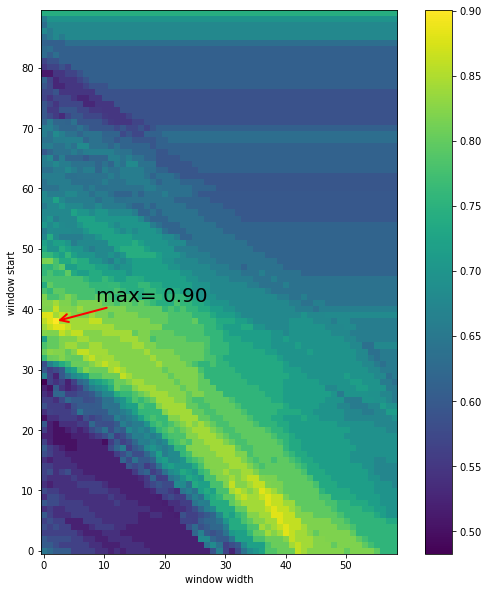

In [36]:
coords = np.where(m_scs[:,:,3] == m_scs[:,:,3].max())
plt.figure(figsize=(10,10))
plt.imshow(m_scs[:,:,3], origin='lower', interpolation='none')
plt.annotate('max={0: .2f}'.format(m_scs[:,:,3].max()), fontsize=20, xy=(coords[1][0], coords[0][0]),
            xycoords='data', xytext=(40, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.,
                            color = 'red'))
plt.xlabel('window width')
plt.ylabel('window start')
plt.colorbar()

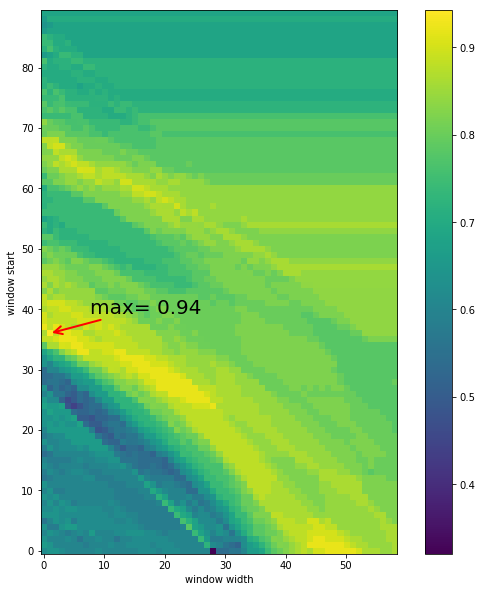

In [37]:
coords = np.where(m_scs[:,:,4] == m_scs[:,:,4].max())
plt.figure(figsize=(10,10))
plt.imshow(m_scs[:,:,4], origin='lower', interpolation='none')
plt.annotate('max={0: .2f}'.format(m_scs[:,:,4].max()), fontsize=20, xy=(coords[1][0], coords[0][0]),
            xycoords='data', xytext=(40, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.,
                            color = 'red'))
plt.xlabel('window width')
plt.ylabel('window start')
plt.colorbar()

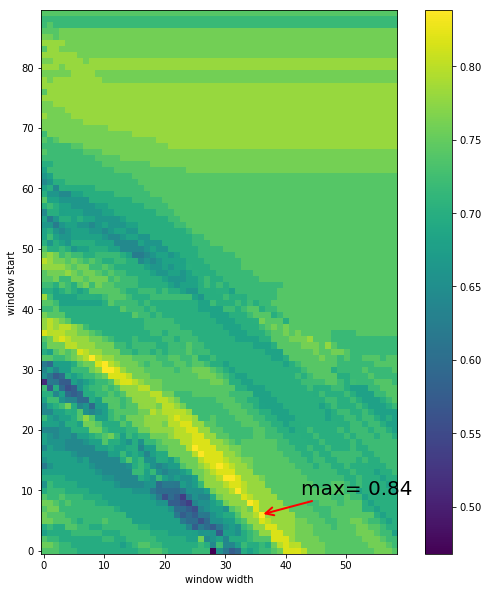

In [38]:
coords = np.where(m_scs[:,:,5] == m_scs[:,:,5].max())
plt.figure(figsize=(10,10))
plt.imshow(m_scs[:,:,5], origin='lower', interpolation='none')
plt.annotate('max={0: .2f}'.format(m_scs[:,:,5].max()), fontsize=20, xy=(coords[1][0], coords[0][0]),
            xycoords='data', xytext=(40, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.,
                            color = 'red'))
plt.xlabel('window width')
plt.ylabel('window start')
plt.colorbar()

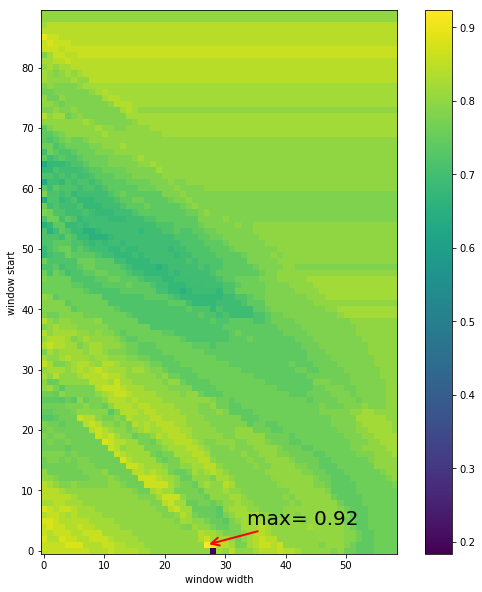

In [39]:
coords = np.where(m_scs[:,:,6] == m_scs[:,:,6].max())
plt.figure(figsize=(10,10))
plt.imshow(m_scs[:,:,6], origin='lower', interpolation='none')
plt.annotate('max={0: .2f}'.format(m_scs[:,:,6].max()), fontsize=20, xy=(coords[1][0], coords[0][0]),
            xycoords='data', xytext=(40, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.,
                            color = 'red'))
plt.xlabel('window width')
plt.ylabel('window start')
plt.colorbar()